### Importing Packages

### Loading Data:
Need to download actual dataset from https://drive.google.com/file/d/1vD4DtyJOIjRzchPtCQu-KPrUjgTiWSmo/view and unzip via Terminal (unzip NeuralNews.zip)

### Creating new environment to avoid clashes
python -m venv /Users/yzhao/ai4allc6g3

Step 1: Filtering to election based articles

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn import metrics

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer

In [2]:
#LDA packages - issue: binary incompatibility
from gensim import corpora
from gensim.models import LdaModel

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/yzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yzhao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
news_df = pd.read_csv("news_dataset.csv")
news_df.head()

,Labels,Articles
0,fake,A longtime champion of the homeless and batter...
1,fake,"Tucked away in the Marais, two warring groups ..."
2,fake,There are plenty of things that can impede wom...
3,fake,"New York City is home to more than 2,500 tiny ..."
4,fake,A man wearing a hat emblazoned with the words ...


In [5]:
news_df.shape

(64000, 2)

In [6]:
snowballStem = SnowballStemmer(language="english")
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

## Vectorizer and Bag of Words Approach

In [7]:
# Convert all articles to lowercase
news_df['Articles'] = [article.lower()for article in news_df["Articles"]]
news_df['Articles'].iloc[:5]

0    a longtime champion of the homeless and batter...
1    tucked away in the marais, two warring groups ...
2    there are plenty of things that can impede wom...
3    new york city is home to more than 2,500 tiny ...
4    a man wearing a hat emblazoned with the words ...
Name: Articles, dtype: object

In [8]:
# Filter the articles to only political articles
filtered_df = news_df[news_df["Articles"].str.contains(""" election|
             campaign| vote| ballot| voting| polling| candidate| nominee| politician|
             leader| opposition| incumbent| poll| polling| approval rating|
             electorate| conservative| liberal| democrat| republican| left-wing|
             right-wing| centrist| far-right| far-left| populist|
             governor| mayor| senator| representative| joe biden| bernie sanders| 
             elizabeth warren| pete buttigieg| andrew yang| tulsi gabbard| 
             kamala harris""", case=False)]

# Clean the labels column into fake (AI generated) versus not fake (human generated)
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.loc[filtered_df["Labels"] == "fake", "Labels"] = 1
filtered_df.loc[filtered_df["Labels"] == "real", "Labels"] = 0
filtered_df = filtered_df.rename(columns={'Labels': 'Fake', 'Articles':'Article'})
filtered_df["Fake"] = filtered_df["Fake"].astype(int)
print(f'The shape of the filtered data frame is: {filtered_df.shape}')
print (f"Number of real articles {filtered_df.shape[0] - sum(filtered_df['Fake'])}")
print (f"Number of AI generated articles {sum(filtered_df['Fake'])}")

The shape of the filtered data frame is: (17278, 2)
Number of real articles 8618
Number of AI generated articles 8660


In [44]:
unprocessed_ai = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
unprocessed_real = pd.DataFrame(filtered_df[filtered_df['Fake']==0])
fake_unprocessed_sample = unprocessed_ai.sample(5000)
real_unprocessed_sample = unprocessed_real.sample(5000)

In [10]:
def text_preprocessing(article):
    """
    article(string): Text to be cleaned for text analysis
    A function that accepts article and removes the punctuation, pronouns,
    and commonly used words that don't provide additional information such as 
    'the', 'a', etc.
    """
    # Remove punctuation
    article = ''.join([char for char in article if char not in string.punctuation])
    # Lemmatization of all non-stop words
    article = ' '.join([lemmatizer.lemmatize(word) for word in article.split() 
                        if word.isalpha() and word not in stop_words])
    
    return article
filtered_df["Cleaned_Article"] = filtered_df["Article"].apply(text_preprocessing)

In [11]:
filtered_df["Cleaned_Article"] = filtered_df["Cleaned_Article"].astype("string")

water crisis california mounting resident santa clarita california battling recordlow water supply many turning bacteriariddled town water supply quench thirst entire month april mayor los angeles public water company sticking vow drinking water neighboring resident complained unpleasant odor negative heat current lack flavor report independent according official onethird santa catchment area san fernando valley contaminated bacteria cause skin irritation skin abscess vomiting company facing uphill battle many customer area draw recharge groundwater community beginning tap backup source water light california drought water come rainfall regularly breached wastewater nearby sewage plant wastewater contains high level nitrate contaminant could prove harmful health believe level nitrate groundwater high particularly compared surrounding area california mike flores public information officer metropolitan water district southern california regional water wholesaler told guardian water polic

In [48]:
ai_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
real_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==0])

fake_processed_sample = ai_articles.sample(n=5000)
real_processed_sample = real_articles.sample(n=5000)

### Word Frequency Analysis
Are there differences in human word choice and AI word choice? Are there any behavioral trends in term frequency?

In [39]:
# Create a bag of words for AI-Generated articles and non-AI generated articles
count_vectorizer = CountVectorizer()
count_vectorizer.fit(filtered_df["Cleaned_Article"])

CountVectorizer()

In [40]:
AI_bag_words = count_vectorizer.transform(fake_processed_sample["Cleaned_Article"])
real_bag_words = count_vectorizer.transform(real_processed_sample["Cleaned_Article"])
AI_word_counts = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(), 
                               'count': AI_bag_words.toarray().sum(axis=0)})
real_word_counts = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(),
                                'count': real_bag_words.toarray().sum(axis=0)})

In [41]:
AI_word_counts.sort_values(by='count', ascending=False, inplace=True)
AI_word_counts.head(20)

,word,count
86470,said,9208
67551,new,7427
110244,would,5585
95063,state,5520
65275,mr,5161
100743,time,5044
78013,president,4997
70842,one,4959
110921,year,4899
102633,trump,4740


In [42]:
real_word_counts.sort_values(by='count', ascending=False, inplace=True)
real_word_counts.head(20)

,word,count
65275,mr,24866
86470,said,23457
110244,would,8126
110921,year,7467
70842,one,7248
67551,new,6807
95063,state,6705
74275,people,5432
56562,like,5332
100743,time,4857


From these two dataframes of most frequently used words and their respective word count, we can observe that the human use of honorifics (Mr) is approximately 380 times more than that of AI. However, outside of this, there seems to be many overlaps between common words. 

In addition, human-generated articles has higher word counts than AI-generated word count. On average, is article length insightful for differentiating between an AI-generated article and human generated article?

In [46]:
fake_unprocessed_sample["Word_Count"] = fake_unprocessed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
real_unprocessed_sample["Word_Count"] = real_unprocessed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")

On average, AI-Generated articles has approximately 
      226.13 words per article.
On average, non AI-Generated articles has approximately 
      316.77 words per article.


In [49]:
fake_processed_sample["Word_Count"] = fake_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
real_processed_sample["Word_Count"] = real_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_processed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_processed_sample['Word_Count'].mean():.2f} words per article.""")

On average, AI-Generated articles has approximately 
      226.67 words per article.
On average, non AI-Generated articles has approximately 
      318.88 words per article.


From above, we can discover that on average non AI-Generated articles has approximately 80 more words than AI-Generated articles.

Do the non AI-Generated articles contain more jargon and fluff? How can we use ngram analysis to analyze the particular context the the words in the dictionaries are used?

In [25]:
def get_ngram3(article, num):
    tokens = article.split()
    ngram_token = list(ngrams(tokens, num))
    counts = Counter(ngram_token)
    return counts

def combine_ngram_frequencies(articles, num, fake):
    """
    articles(string): A column of text to be used for n-gram analysis
    num (positive, non-zero integer): The amount of words per tuple used for 
    analysis
    fake (1 or 0): Indicates if the column of articles inputted are fake 
    (AI-Generated) or not. Should be 1 if the articles are AI-Generated. Should
    be 0 if the articles are human composed.

    Returns a dataframe containing cumulative n-gram tuples, frequencies, and
    source (whether the n-gram tuples are from AI-generated sources or not).
    """
    assert isinstance(num, int)
    combined_counts = Counter()
    
    for article in articles:
        counts = get_ngram3(article, num)
        combined_counts.update(counts)
    
    # Convert the combined counts to a DataFrame
    freq_df = pd.DataFrame(combined_counts.items(), columns=[f'{num}gram', 'frequency'])
    freq_df["fake"] = fake

    # Ensure the frequency column is of type int
    freq_df['frequency'] = freq_df['frequency'].astype(int)

    # Convert the n-gram tuples to strings for better readability
    freq_df[f'{num}gram'] = freq_df[f'{num}gram'].apply(lambda x: ' '.join(x))

    # Sort the DataFrame by frequency in descending order
    freq_df = freq_df.sort_values(by='frequency', ascending=False)
    freq_df.reset_index(inplace=True, drop=True)
    return freq_df

In [32]:
unprocessed_fake_5gram = combine_ngram_frequencies(
    fake_unprocessed_sample["Article"], 5, 1
    )
unprocessed_real_5gram = combine_ngram_frequencies(real_unprocessed_sample["Article"], 5, 0)

In [36]:
merged_unprocessed = pd.concat([unprocessed_fake_5gram, unprocessed_real_5gram])
merged_unprocessed = merged_unprocessed.sort_values(by="frequency", ascending=False)
merged_unprocessed.reset_index(inplace=True, drop=True)
top75 = merged_unprocessed.head(75)

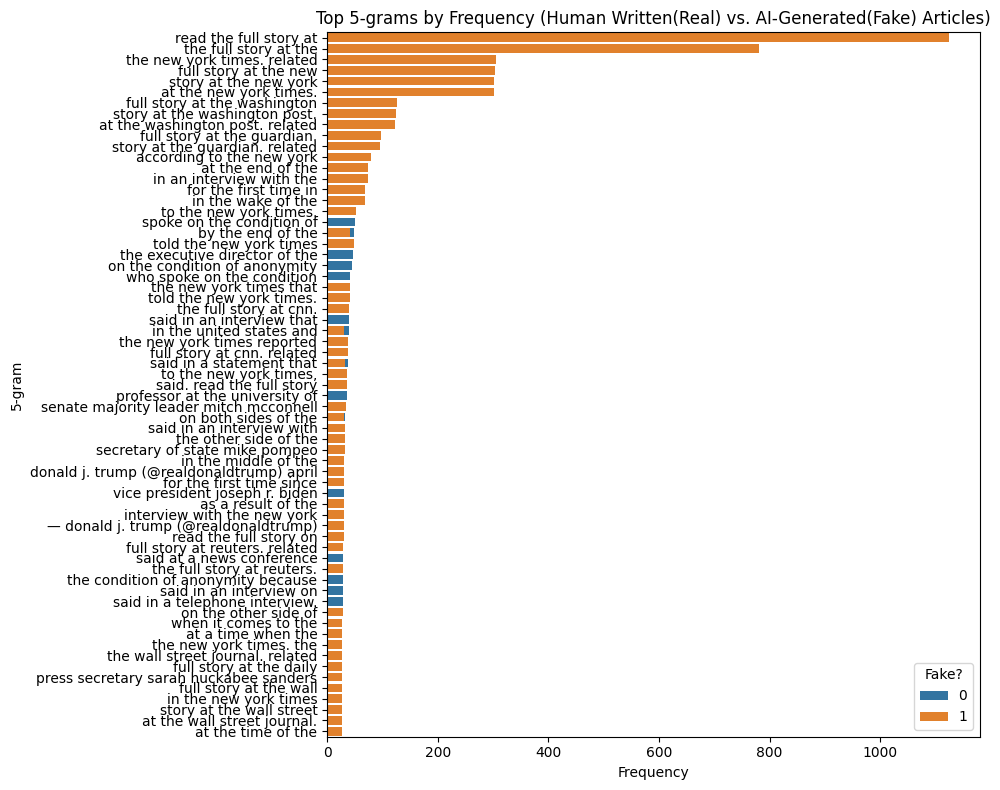

In [37]:
plt.figure(figsize=(10, 8))

sns.barplot(
    data=top75,
    x="frequency",
    y="5gram",
    hue="fake",
    dodge=False
)

plt.title("Top 5-grams by Frequency (Human Written(Real) vs. AI-Generated(Fake) Articles)")
plt.xlabel("Frequency")
plt.ylabel("5-gram")
plt.legend(title="Fake?")
plt.tight_layout()
plt.show()

In [18]:
# def get_ngram(article, num):
#     tokens = article.split()
#     ngram_token = list(ngrams(tokens, num))
#     return ngram_token

# def get_ngram2(article, num):
#     assert isinstance(num, int)
#     tokens = article.split()

#     ngram_token = list(ngrams(tokens, num))

#     counts = Counter(ngram_token)
#     freq_df = pd.DataFrame(counts.items(), columns=[f'{num}gram', 'frequency'])

#     freq_df['frequency'] = freq_df['frequency'].astype(int)
#     freq_df[f'{num}gram'] = freq_df[f'{num}gram'].astype(str)
#     freq_df = freq_df.sort_values(by='frequency', ascending=False)
#     freq_df.reset_index(inplace=True, drop = True)
#     print (freq_df.head(20))
#     print (freq_df.shape)
#     return freq_df

In [111]:
# top30_fake = pd.DataFrame(f_trigram_df.iloc[:30,])
# top30_fake["source"] = "fake"
# top30_real = pd.DataFrame(r_trigram_df.iloc[:30,])
# top30_real["source"] = "real"
# merged_top30 = pd.concat([top30_real, top30_fake])
# merged_top30 = merged_top30.sort_values(by="frequency", ascending=False)
# merged_top30.head()

In [ ]:
# ftest_df["5gram"] = ftest_df["Cleaned_Article"].apply(lambda x: get_ngram(x, 5))
# f_all_trigrams = sum(ftest_df['5gram'], [])
# f_trigram_counts = Counter(f_all_trigrams)
# f_trigram_df = pd.DataFrame(f_trigram_counts.items(), columns=['5gram', 'frequency'])
# f_trigram_df['frequency'] = f_trigram_df['frequency'].astype(int)
# f_trigram_df = f_trigram_df.sort_values(by='frequency', ascending=False)
# f_trigram_df.reset_index(inplace=True, drop = True)
# f_trigram_df['5gram'] = f_trigram_df['5gram'].astype("string")
# f_trigram_df.head()
# rtest_df["5gram"] = rtest_df["Cleaned_Article"].apply(lambda x: get_ngram(x, 5))
# r_all_trigrams = sum(rtest_df['5gram'], [])
# r_trigram_counts = Counter(r_all_trigrams)
# r_trigram_df = pd.DataFrame(r_trigram_counts.items(), columns=['5gram', 'frequency'])
# r_trigram_df['frequency'] = r_trigram_df['frequency'].astype(int)
# r_trigram_df = r_trigram_df.sort_values(by='frequency', ascending=False)
# r_trigram_df.reset_index(inplace=True, drop = True)
# r_trigram_df['5gram'] = r_trigram_df['5gram'].astype("string")
# r_trigram_df.head()

In [32]:
# def extract_ngrams(data, n):
#     n_grams = ngrams(nltk.word_tokenize(data), n)
#     n_counter = Counter(n_grams)
#     freq = pd.DataFrame(n_counter.items(), columns=["Words", "Frequency"]).sort_values(by = "Frequency")
#     return freq

# ai_two_gram = pd.concat(ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2)))
# accumulated_ngrams = ai_two_gram.groupby("Words", as_index=False).sum()
# accumulated_ngrams.head()

# accumulated_ngrams.shape

<!-- ai_two_gram['Words'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2))
ai_two_gram['Frequency'] = Counter()
ai_three_gram['3_gram'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 3))
ai_articles['4_gram'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 4))

two_gram['2_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2))
real_articles['3_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 3))
real_articles['4_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 4)) -->

### KMeans Clustering with Inverse Document Frequency (IDF)Normalization 
References Used: https://scikit-learn.org/1.5/auto_examples/text/plot_document_clustering.html

In [55]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, stop_words="english")
processed_merged_df = pd.concat([real_processed_sample, fake_processed_sample])
X_tfidf = vectorizer.fit_transform(processed_merged_df["Cleaned_Article"])
print(processed_merged_df.shape)

(10000, 4)


#embed document into array and project them into an emeddy space -> PCA (reduce densionaly) -> noticiable cluster
#clustering document embedding

In [56]:
# True labels for evaluation
labels = processed_merged_df["Fake"].tolist()
evaluations = []
evaluations_std = []

# Define the evaluation function
def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    scores = defaultdict(list)
    
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))
    
    evaluation = {"estimator": name}
    evaluation_std = {"estimator": name}
    
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

# Perform clustering and evaluation
kmeans = KMeans(n_clusters=2, max_iter=100, n_init=5)
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")


Homogeneity: 0.019 ± 0.003
Completeness: 0.024 ± 0.004
V-measure: 0.021 ± 0.003
Adjusted Rand-Index: 0.019 ± 0.003
Silhouette Coefficient: 0.003 ± 0.000


In [34]:
# fake_tfidf = tfidf_vectorizer.fit_transform(filtered_df["Cleaned_Article"])
# tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()
# count_vocabulary = count_vectorizer.get_feature_names_out(word_counts)
# size_tfidf = tfidf_vocabulary.shape[0]
# size_vocab = count_vocabulary.shape[0]
# size_compare = np.round(size_tfidf / size_vocab, 2)
# print ("Size of tfidf vocabulary is " + str(size_compare) +
#       " of the overall vocabulary.")
# print (tfidf_vocabulary)

## Classification of article party alignment

In [35]:
# installs used 
# pip install transformers
# pip install ipywidgets
# pip3 install torch torchvision torchaudio (may vary based on device)
# pip install tensorflow
# pip install tf_keras
# Load model directly
# from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline

# pipe = pipeline("text-classification", model="launch/POLITICS")
# news_sample = news_df.sample(n = 10)
# def classify_party(article):
#     result = pipe(article)[0]
#     return (pd.Series([result['label'], result['score']]))
# def find_leng(article):
#     return (len(article.split()) < 500)
# short_articles = news_sample[news_sample["Cleaned_Article"].apply(find_leng)]
# short_articles
#short_articles.shape
#for article in short_articles["Cleaned_Article"]:
    #if (len(article.split()) >= 512):
        # print (len(article.split()))
#short_articles[['label', 'confidence']] = short_articles['Cleaned_Article'].apply(classify_party)
#tokenizer = AutoTokenizer.from_pretrained("launch/POLITICS")
#model = AutoModelForMaskedLM.from_pretrained("launch/POLITICS")
#encoded = short_articles['Cleaned_Article'].apply(tokenizer, return_tensors="pt")
# text = short_articles['Cleaned_Article'].iloc[1]
# tokenizer(text, return_tensors="pt")

how to detact if it's AI?
- missing out on the functionality of the AI part (deterministic)
- clustering (defining the features: liklihoold of words in AI or non-AI, neural network (every possible word combo))
- classification, clustering with NLP, neural networks (with words)

## Word Frequency Analysis